## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [113]:
# # Mounting google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [114]:
# # Setting toolkit folder as working directory

# %cd /content/drive/My Drive/Project8_SentimentAnalysis_with_NeuralNetwork
# ! ls

In [115]:
!pip install tensorflow


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [116]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [118]:
# Custom pad_sequences function to avoid numpy compatibility issues
def pad_sequences(sequences, padding='post', truncating='pre', maxlen=None, value=0):
    """Custom implementation of pad_sequences to avoid numpy compatibility issues"""
    import numpy as np
    if not sequences:
        return np.array([])
    
    if maxlen is None:
        maxlen = max(len(seq) for seq in sequences)
    
    padded_sequences = []
    for seq in sequences:
        seq = list(seq)
        if len(seq) > maxlen:
            if truncating == 'pre':
                seq = seq[-maxlen:]
            else:
                seq = seq[:maxlen]
        
        if len(seq) < maxlen:
            padding_length = maxlen - len(seq)
            if padding == 'post':
                seq = seq + [value] * padding_length
            else:
                seq = [value] * padding_length + seq
        
        padded_sequences.append(seq)
    
    return np.array(padded_sequences)

## Loading dataset

In [119]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [120]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [121]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [122]:
# Checking for missing values

movie_reviews.isnull().values.any()

np.False_

<Axes: xlabel='sentiment', ylabel='count'>

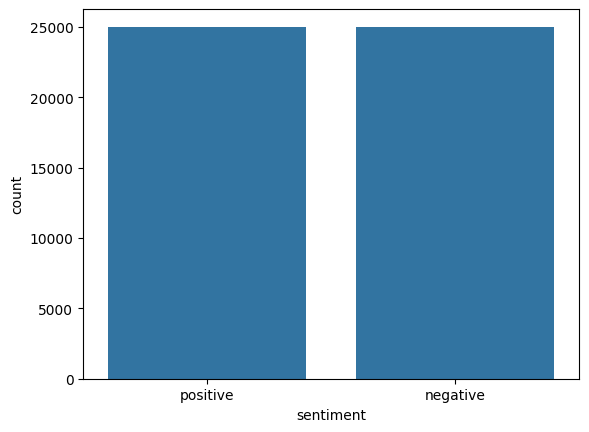

In [123]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [124]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [125]:
# import b2_preprocessing_function
from b2_preprocessing_function import CustomPreprocess

In [126]:
custom = CustomPreprocess()
custom.preprocess_text("Those were the best days of my life!")

'best days life '

In [127]:
# TAG_RE = re.compile(r'<[^>]+>')

# def remove_tags(text):
#     '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

#     return TAG_RE.sub('', text)

In [128]:
# import nltk
# nltk.download('stopwords')

In [129]:
# def preprocess_text(sen):
#     '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
#     in lowercase'''
    
#     sentence = sen.lower()

#     # Remove html tags
#     sentence = remove_tags(sentence)

#     # Remove punctuations and numbers
#     sentence = re.sub('[^a-zA-Z]', ' ', sentence)

#     # Single character removal
#     sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

#     # Remove multiple spaces
#     sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

#     # Remove Stopwords
#     pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
#     sentence = pattern.sub('', sentence)

#     return sentence

In [130]:
# Calling preprocessing_text function on movie_reviews

# Initialize the custom preprocessor
custom = CustomPreprocess()

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))

In [131]:
# Sample cleaned up movie review 

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [132]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [134]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [135]:
import io
import json

In [136]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [137]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [138]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [139]:
# Create LSTM Model WITHOUT pre-trained embeddings (since GloVe file is missing)
# This will train from scratch with the IMDb dataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

print("🔧 Creating fresh LSTM model for training...")

lstm_model_fresh = Sequential([
    Embedding(vocab_length, 100, input_length=maxlen, name='embedding_2'),  # Trainable embeddings
    LSTM(128, name='lstm'),
    Dense(1, activation='sigmoid', name='dense_2')
])

# Build the model to show proper summary
lstm_model_fresh.build(input_shape=(None, maxlen))

lstm_model_fresh.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("✅ Fresh LSTM model created successfully!")
print(lstm_model_fresh.summary())

🔧 Creating fresh LSTM model for training...
✅ Fresh LSTM model created successfully!


/Users/dhritireddy/Desktop/sentiment-analysis-with-deep-neural-networks-main/sentiment_env/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,356,777 (35.69 MB)

 Trainable params: 9,356,777 (35.69 MB)

 Non-trainable params: 0 (0.00 B)

None


In [140]:
# Load GloVe word embeddings and create an Embeddings Dictionary
# If GloVe file doesn't exist, we'll use trainable embeddings instead

from numpy import asarray
from numpy import zeros
import os

embeddings_dictionary = dict()
use_pretrained_embeddings = False

# Check if GloVe file exists
if os.path.exists('glove.6B.100d.txt'):
    print("Loading GloVe embeddings...")
    glove_file = open('glove.6B.100d.txt', encoding="utf8")
    
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()
    use_pretrained_embeddings = True
    print(f"Loaded {len(embeddings_dictionary)} word embeddings")
else:
    print("GloVe file not found. Will use trainable embeddings instead.")
    use_pretrained_embeddings = False

GloVe file not found. Will use trainable embeddings instead.


In [141]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

if use_pretrained_embeddings:
    embedding_matrix = zeros((vocab_length, 100))
    for word, index in word_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    print(f"Created embedding matrix with shape {embedding_matrix.shape}")
else:
    # Use random initialization for embeddings (will be trained)
    embedding_matrix = None
    print("Will use trainable embeddings initialized randomly")

Will use trainable embeddings initialized randomly


In [142]:
# Check embedding matrix status
if embedding_matrix is not None:
    print(f"Embedding matrix shape: {embedding_matrix.shape}")
else:
    print("No pre-trained embeddings loaded. Using trainable embeddings instead.")
    print(f"Vocabulary size: {vocab_length}")
    print("Embedding dimension: 100")

No pre-trained embeddings loaded. Using trainable embeddings instead.
Vocabulary size: 92394
Embedding dimension: 100


# Model Training with:

## Simple Neural Network

In [143]:
# Neural Network architecture

snn_model = Sequential()

if use_pretrained_embeddings and embedding_matrix is not None:
    # Use pre-trained GloVe embeddings
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    print("Using pre-trained GloVe embeddings (frozen)")
else:
    # Use trainable embeddings
    embedding_layer = Embedding(vocab_length, 100, input_length=maxlen, trainable=True)
    print("Using trainable embeddings")

snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

Using trainable embeddings


In [144]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model to show proper summary
snn_model.build(input_shape=(None, maxlen))

print(snn_model.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │        10,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,249,401 (35.28 MB)

 Trainable params: 9,249,401 (35.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [145]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7770 - loss: 0.4688 - val_accuracy: 0.8851 - val_loss: 0.2891
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7770 - loss: 0.4688 - val_accuracy: 0.8851 - val_loss: 0.2891
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9350 - loss: 0.1804 - val_accuracy: 0.8831 - val_loss: 0.2813
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9350 - loss: 0.1804 - val_accuracy: 0.8831 - val_loss: 0.2813
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9841 - loss: 0.0674 - val_accuracy: 0.8816 - val_loss: 0.2950
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9841 - loss: 0.0674 - val_accuracy: 0.8816 - val_loss: 0.2950
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9966 - loss: 0.0243 - val_accuracy: 0.8813 - val_loss: 0.3174
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9966 - loss: 0.0243 - val_accuracy: 0.

In [146]:
# # Model training

# snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [147]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.8786 - loss: 0.3523
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.8786 - loss: 0.3523


In [148]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3523147702217102
Test Accuracy: 0.878600001335144


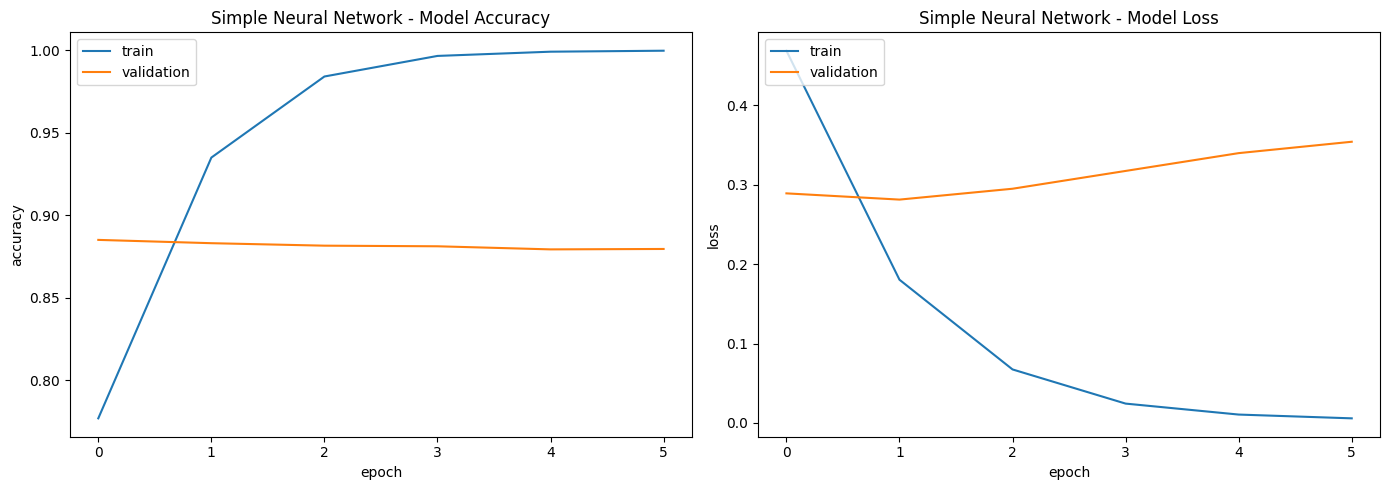

In [149]:
# Model Performance Charts

import matplotlib.pyplot as plt

# Check which metric names are available
metric_keys = list(snn_model_history.history.keys())
accuracy_key = 'accuracy' if 'accuracy' in metric_keys else 'acc'
val_accuracy_key = 'val_accuracy' if 'val_accuracy' in metric_keys else 'val_acc'

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(snn_model_history.history[accuracy_key])
plt.plot(snn_model_history.history[val_accuracy_key])
plt.title('Simple Neural Network - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])
plt.title('Simple Neural Network - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Convolutional Neural Network

In [150]:
from keras.layers import Conv1D

In [151]:
# Neural Network architecture

cnn_model = Sequential()

if use_pretrained_embeddings and embedding_matrix is not None:
    # Use pre-trained GloVe embeddings
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    print("Using pre-trained GloVe embeddings (frozen)")
else:
    # Use trainable embeddings
    embedding_layer = Embedding(vocab_length, 100, input_length=maxlen, trainable=True)
    print("Using trainable embeddings")

cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

Using trainable embeddings


In [152]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model to show proper summary
cnn_model.build(input_shape=(None, maxlen))

print(cnn_model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,303,657 (35.49 MB)

 Trainable params: 9,303,657 (35.49 MB)

 Non-trainable params: 0 (0.00 B)

None


In [153]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7899 - loss: 0.4550 - val_accuracy: 0.8491 - val_loss: 0.3447
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7899 - loss: 0.4550 - val_accuracy: 0.8491 - val_loss: 0.3447
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9087 - loss: 0.2360 - val_accuracy: 0.8639 - val_loss: 0.3329
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9087 - loss: 0.2360 - val_accuracy: 0.8639 - val_loss: 0.3329
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9647 - loss: 0.1046 - val_accuracy: 0.8605 - val_loss: 0.3808
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9647 - loss: 0.1046 - val_accuracy: 0.8605 - val_loss: 0.3808
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9928 - loss: 0.0325 - val_accuracy: 0.8569 - val_loss: 0.4452
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9928 - loss: 0.0325 - val_accuracy: 0.

In [154]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8547 - loss: 0.5262
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8547 - loss: 0.5262


In [155]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5261996388435364
Test Accuracy: 0.8547000288963318


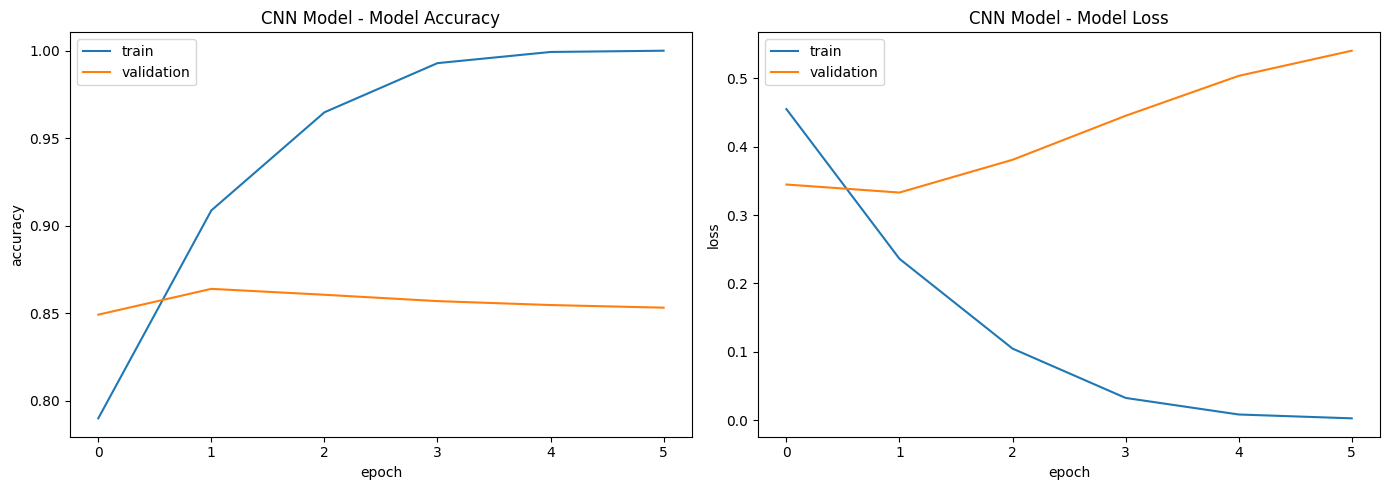

In [156]:
# Model Performance Charts

import matplotlib.pyplot as plt

# Check which metric names are available
metric_keys = list(cnn_model_history.history.keys())
accuracy_key = 'accuracy' if 'accuracy' in metric_keys else 'acc'
val_accuracy_key = 'val_accuracy' if 'val_accuracy' in metric_keys else 'val_acc'

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_model_history.history[accuracy_key])
plt.plot(cnn_model_history.history[val_accuracy_key])
plt.title('CNN Model - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('CNN Model - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Recurrent Neural Network (LSTM)

In [157]:
from keras.layers import LSTM

In [158]:
# Neural Network architecture

lstm_model = Sequential()

if use_pretrained_embeddings and embedding_matrix is not None:
    # Use pre-trained GloVe embeddings
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    print("Using pre-trained GloVe embeddings (frozen)")
else:
    # Use trainable embeddings
    embedding_layer = Embedding(vocab_length, 100, input_length=maxlen, trainable=True)
    print("Using trainable embeddings")

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

Using trainable embeddings


In [159]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model to show proper summary
lstm_model.build(input_shape=(None, maxlen))

print(lstm_model.summary())

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,356,777 (35.69 MB)

 Trainable params: 9,356,777 (35.69 MB)

 Non-trainable params: 0 (0.00 B)

None


In [160]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.7778 - loss: 0.4550 - val_accuracy: 0.8801 - val_loss: 0.3000
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.7778 - loss: 0.4550 - val_accuracy: 0.8801 - val_loss: 0.3000
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.7976 - loss: 0.4665 - val_accuracy: 0.8583 - val_loss: 0.3778
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.7976 - loss: 0.4665 - val_accuracy: 0.8583 - val_loss: 0.3778
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.9197 - loss: 0.2351 - val_accuracy: 0.8725 - val_loss: 0.3336
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.9197 - loss: 0.2351 - val_accuracy: 0.8725 - val_loss: 0.3336
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 0.9573 - loss: 0.1337 - val_accuracy: 0.8726 - val_loss: 0.3774
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 0.9573 - loss: 0.1337 - 

In [161]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8646 - loss: 0.4636
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8646 - loss: 0.4636


In [162]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4635878801345825
Test Accuracy: 0.8646000027656555


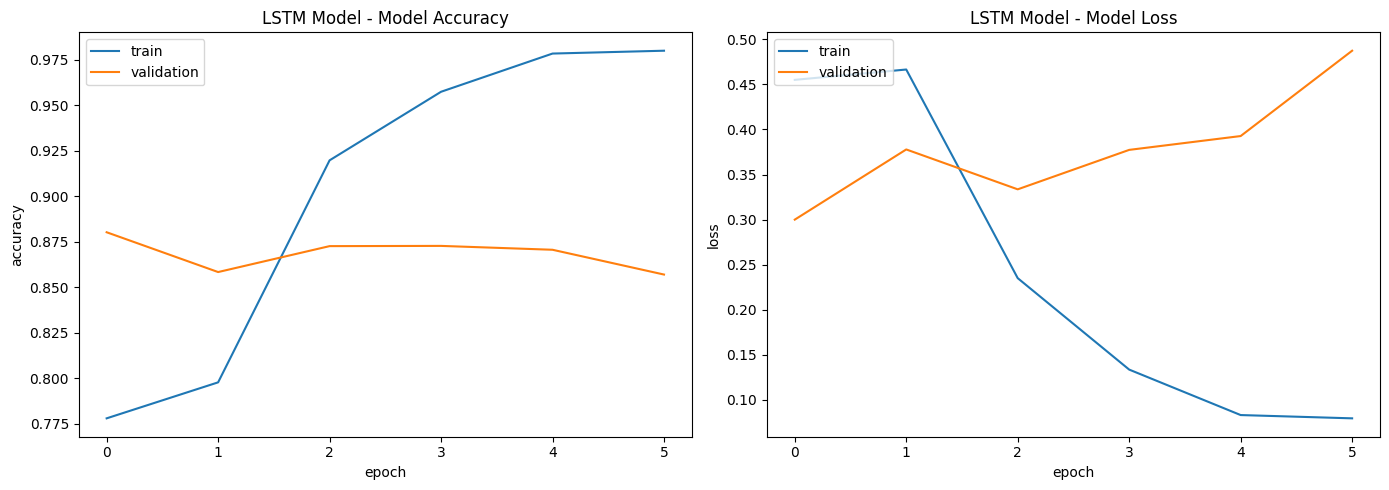

In [163]:
# Model Performance Charts

import matplotlib.pyplot as plt

# Check which metric names are available
metric_keys = list(lstm_model_history.history.keys())
accuracy_key = 'accuracy' if 'accuracy' in metric_keys else 'acc'
val_accuracy_key = 'val_accuracy' if 'val_accuracy' in metric_keys else 'val_acc'

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_model_history.history[accuracy_key])
plt.plot(lstm_model_history.history[val_accuracy_key])
plt.title('LSTM Model - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.title('LSTM Model - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [164]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [165]:
pwd # lists files in working directory

'/Users/dhritireddy/Desktop/sentiment-analysis-with-deep-neural-networks-main'

In [ ]:
# Load previously trained LSTM Model

from tensorflow.keras.models import load_model

# Try to load the new retrained model first, fall back to original if not available
if os.path.exists('c1_lstm_model_new.h5'):
    model_path = 'c1_lstm_model_new.h5'
    print("Loading new retrained model...")
elif os.path.exists('c1_lstm_model_acc_0.864.h5'):
    model_path = 'c1_lstm_model_acc_0.864.h5'
    print("Loading original model...")
else:
    print("No trained model found. Please train a model first.")
    model_path = None

if model_path:
    pretrained_lstm_model = load_model(model_path)
    print(f"Model loaded from {model_path}")
    # summarize model.
    pretrained_lstm_model.summary()

Loading new retrained model...


Model loaded from c1_lstm_model_new.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 128)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 64)               │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,523 (2.64 MB)

 Trainable params: 691,521 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a2_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = custom.preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
unseen_processed

['intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie 

In [ ]:
from keras_preprocessing.text import tokenizer_from_json

In [ ]:
# Loading tokenizer
# Try to load the new tokenizer first, fall back to original if not available
if os.path.exists('b3_tokenizer_new.json'):
    tokenizer_path = 'b3_tokenizer_new.json'
    print("Loading new tokenizer...")
elif os.path.exists('b3_tokenizer.json'):
    tokenizer_path = 'b3_tokenizer.json'
    print("Loading original tokenizer...")
else:
    print("No tokenizer found. Please train a model first.")
    tokenizer_path = None

if tokenizer_path:
    with open(tokenizer_path) as f:
        data = f.read()
        loaded_tokenizer = tokenizer_from_json(data)
    print(f"Tokenizer loaded from {tokenizer_path}")

Loading new tokenizer...
Tokenizer loaded from b3_tokenizer_new.json


In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [ ]:
unseen_tokenized

[[925,
  1,
  1,
  400,
  1289,
  627,
  1266,
  511,
  1524,
  97,
  1863,
  1370,
  1,
  3416,
  16,
  4,
  25,
  140,
  716,
  2161,
  1270,
  18,
  199,
  659,
  76,
  1378,
  4780,
  1464,
  4780,
  2013,
  1034,
  33,
  83,
  463,
  435,
  879,
  1740,
  282,
  1469,
  150,
  626,
  3,
  1434,
  1291,
  3,
  62,
  1,
  806,
  4114,
  1989,
  191,
  806,
  51,
  854,
  13,
  88,
  11,
  16,
  4012,
  1,
  589,
  1958,
  1398,
  93,
  113,
  1014,
  24,
  270,
  1,
  2759,
  62,
  1014,
  1,
  25,
  315,
  1064,
  115,
  1852,
  736,
  1,
  1776,
  1,
  315,
  3822,
  18,
  383,
  3822,
  569,
  1,
  4051,
  24,
  284,
  164,
  624,
  261,
  1,
  83,
  294,
  1776,
  1,
  1011,
  213,
  278,
  1374,
  1040,
  3822,
  897,
  17,
  151,
  312,
  1264,
  1,
  1928,
  285,
  1602,
  1,
  3172,
  1,
  122,
  659,
  140,
  1645,
  1615,
  937],
 [2273,
  87,
  2421,
  1040,
  1090,
  2494,
  1850,
  281,
  262,
  463,
  978,
  238,
  3479,
  1189,
  1189,
  743,
  87,
  743,
  3702,
  18

In [ ]:
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [ ]:
unseen_padded

array([[  76, 1378, 4780, 1464, 4780, 2013, 1034,   33,   83,  463,  435,
         879, 1740,  282, 1469,  150,  626,    3, 1434, 1291,    3,   62,
           1,  806, 4114, 1989,  191,  806,   51,  854,   13,   88,   11,
          16, 4012,    1,  589, 1958, 1398,   93,  113, 1014,   24,  270,
           1, 2759,   62, 1014,    1,   25,  315, 1064,  115, 1852,  736,
           1, 1776,    1,  315, 3822,   18,  383, 3822,  569,    1, 4051,
          24,  284,  164,  624,  261,    1,   83,  294, 1776,    1, 1011,
         213,  278, 1374, 1040, 3822,  897,   17,  151,  312, 1264,    1,
        1928,  285, 1602,    1, 3172,    1,  122,  659,  140, 1645, 1615,
         937],
       [3996,   72, 1149, 2443,   28, 1884, 1125,  624,   35,  428, 3948,
        1021,    2, 1179,   17, 2208,  265,  313, 1523, 1550, 2140, 3575,
         636,  405, 4808, 2521,  184,  167,  220,   41,  121,  234,  352,
         630,   20,   72, 1400, 2885, 3633, 1645,   25, 1335,   26,  281,
        1574, 1143,  28

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


array([[0.88425255],
       [0.97051823],
       [0.10786386],
       [0.02200918],
       [0.9818051 ],
       [0.10103585]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.7
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,0.2
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,1.0


In [ ]:
unseen_sentiments

array([[0.88425255],
       [0.97051823],
       [0.10786386],
       [0.02200918],
       [0.9818051 ],
       [0.10103585]], dtype=float32)

In [ ]:
unseen_sentiments[0][0]

np.float32(0.88425255)

In [ ]:
prediction_text= f"Positive Review with probable IMDb rating as: {np.round(unseen_sentiments[0][0]*10,1)}"

In [ ]:
prediction_text

'Positive Review with probable IMDb rating as: 8.800000190734863'